In [1]:
# --- CÀI ĐẶT THƯ VIỆN ---
!pip install -q timm

import os
import sys
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import timm 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Cấu hình GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị đang dùng: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU '}")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Thiết bị đang dùng: Tesla P100-PCIE-16GB


In [2]:
# Danh sách 50 loại trái cây tập trung vào các nhóm dễ nhầm lẫn
SELECTED_CLASSES = [
    'Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3',
    'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3',
    'Apple Red Delicious', 'Apple Red Yellow 1',
    'Orange', 'Mandarine', 'Clementine', 'Tangelo', 'Grapefruit Pink', 'Grapefruit White',
    'Pear', 'Pear Abate', 'Pear Kaiser', 'Pear Monster', 'Pear Williams',
    'Avocado', 'Avocado ripe', 'Banana', 'Mango', 'Mango Red', 'Papaya', 'Pineapple', 'Pitahaya Red',
    'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato Cherry Red', 'Tomato Maroon',
    'Pepper Red', 'Pepper Green',
    'Apricot', 'Nectarine', 'Peach', 'Plum', 'Kiwi', 'Lemon', 'Lime',
    'Strawberry', 'Raspberry', 'Potato Red', 'Potato White', 'Ginger Root'
]

print(f" Đã cấu hình {len(SELECTED_CLASSES)} lớp mục tiêu.")

 Đã cấu hình 50 lớp mục tiêu.


In [3]:
SELECTED_CLASSES = [
    # 1. NHÓM TÁO (Apple) - Rất nhiều loại, dễ tráo hàng nhất
    'Apple Braeburn 1',       # Táo nhập khẩu
    'Apple Crimson Snow 1',   # Táo tuyết (Đắt)
    'Apple Golden 1',         # Táo vàng
    'Apple Granny Smith 1',   # Táo xanh (Dễ nhận diện nhưng vẫn cần học)
    'Apple Pink Lady 1',      # Táo Pink Lady (Thương hiệu đắt tiền)
    'Apple Red 1',            # Táo đỏ thường (Giá rẻ -> Dùng để tráo)
    'Apple Red Delicious 1',  # Táo đỏ Mỹ
    'Apple Red Yellow 1',     # Táo lai

    # 2. NHÓM LÊ (Pear) - Hình dáng lồi lõm, khó phân biệt
    'Pear 1',                 # Lê thường
    'Pear Abate 1',           # Lê Abate (Dài)
    'Pear Forelle 1',         # Lê Forelle (Có chấm đỏ)
    'Pear Kaiser 1',          # Lê nâu (Vỏ nhám)
    'Pear Monster 1',         # Lê khổng lồ
    'Pear Williams 1',        # Lê Williams

    # 3. NHÓM CÀ CHUA (Tomato) - Gian lận Cà chua bi vs Cà chua thường
    'Tomato 1',               # Cà chua thường
    'Tomato Cherry Red 1',    # Cà chua bi (Cherry) -> Giá cao hơn nhiều
    'Tomato Heart 1',         # Cà chua tim (Beefsteak) -> Hàng cao cấp
    'Tomato Maroon 1',        # Cà chua đen/nâu (Heirloom)
    'Tomato Yellow 1',        # Cà chua vàng

    # 4. NHÓM CAM QUÝT (Citrus) - Dễ nhầm lẫn
    'Orange 1',               # Cam
    'Mandarine 1',            # Quýt
    'Clementine 1',           # Quýt Clementine (Nhỏ, ngọt)
    'Tangelo 1',              # Quả lai Cam-Bưởi
    'Grapefruit Pink 1',      # Bưởi hồng
    'Grapefruit White 1',     # Bưởi trắng
    'Lemon 1',                # Chanh vàng
    'Limes 1',                # Chanh xanh

    # 5. NHÓM TRÁI CÂY NHIỆT ĐỚI GIÁ TRỊ CAO (High Value)
    'Avocado 1',              # Bơ sáp xanh
    'Avocado ripe 1',         # Bơ chín (Vỏ đen - Hass)
    'Mango 1',                # Xoài xanh/vàng
    'Mango Red 1',            # Xoài đỏ (Xoài Úc/Đài Loan - Đắt)
    'Papaya 1',               # Đu đủ
    'Pineapple 1',            # Thơm/Dứa
    'Pitahaya Red 1',         # Thanh long đỏ (Đắt hơn trắng)
    'Passion Fruit 1',        # Chanh dây
    'Mangostan 1',            # Măng cụt (Giá trị cao)
    'Pomegranate 1',          # Lựu

    # 6. NHÓM ĐÀO MẬN (Stone Fruits)
    'Nectarine 1',            # Đào trơn
    'Peach 1',                # Đào lông
    'Peach Flat 1',           # Đào dẹt (Đào bánh rán - Đắt)
    'Plum 1',                 # Mận
    'Apricot 1',              # Mơ

    # 7. NHÓM RAU CỦ & KHÁC (Để kiểm tra độ đa dạng)
    'Pepper Red 1',           # Ớt chuông đỏ
    'Pepper Green 1',         # Ớt chuông xanh (Rẻ hơn đỏ/vàng)
    'Pepper Yellow 1',        # Ớt chuông vàng
    'Potato Red 1',           # Khoai tây đỏ
    'Potato White 1',         # Khoai tây trắng (Thường rẻ hơn)
    'Ginger Root 1',          # Gừng
    'Cucumber 1',             # Dưa leo
    'Banana 1'                # Chuối (Mặt hàng phổ biến nhất để đối chứng)
]


In [4]:
DATASET_ROOT = ""
found = False

for root, dirs, files in os.walk('/kaggle/input'):
    if 'Training' in dirs and 'Test' in dirs:
        DATASET_ROOT = root
        found = True
        break


TRAIN_DIR = os.path.join(DATASET_ROOT, 'Training')
TEST_DIR = os.path.join(DATASET_ROOT, 'Test')
print(f" Đã tìm thấy Dataset tại: {DATASET_ROOT}")
print(f"    Train Dir: {TRAIN_DIR}")
print(f"    Test Dir:  {TEST_DIR}")


 Đã tìm thấy Dataset tại: /kaggle/input/fruits/fruits-360_100x100/fruits-360
    Train Dir: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
    Test Dir:  /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test


In [5]:
class SelectiveImageFolder(datasets.ImageFolder):
    """
    Load những folder nào có tên nằm trong SELECTED_CLASSES.
    """
    def find_classes(self, directory):
        # Lấy tất cả folder có trong thư mục
        all_classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        
        # Chỉ giữ lại các lớp nằm trong danh sách chọn lọc
        classes = [c for c in all_classes if c in SELECTED_CLASSES]
        
        # Báo lỗi nếu không tìm thấy
        if not classes:
            raise FileNotFoundError(f"Không tìm thấy lớp nào trong danh sách lọc tại {directory}")
            
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [6]:
def get_data(img_size, batch_size=16):
    """
    Gọi hàm này khi bắt đầu Train.
    - img_size: Điền kích thước ảnh đầu vào.
    """
    print(f" Load dữ liệu với size: {img_size}x{img_size}...")
    
    # Lúc này mới Transform
    tsfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load dataset
    train_ds = SelectiveImageFolder(TRAIN_DIR, transform=tsfm)
    val_ds = SelectiveImageFolder(TEST_DIR, transform=tsfm)
    
    # Tạo Loader
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_dl, val_dl, train_ds.classes

In [7]:
if 'TRAIN_DIR' not in globals():
    TRAIN_DIR = os.path.join(DATASET_ROOT, 'Training')
    TEST_DIR = os.path.join(DATASET_ROOT, 'Test')

def get_filtered_classes(dir_path):
    if not os.path.exists(dir_path): 
        return set()
    
    all_folders = set(os.listdir(dir_path))
    
    filtered = all_folders.intersection(set(SELECTED_CLASSES))
    
    return filtered

train_classes = get_filtered_classes(TRAIN_DIR)
test_classes = get_filtered_classes(TEST_DIR)

print(f"\n SỐ LƯỢNG LỚP TÌM THẤY (Trong danh sách 50 loại):")
print(f"   - Train: {len(train_classes)} / 50")
print(f"   - Test:  {len(test_classes)} / 50")


 SỐ LƯỢNG LỚP TÌM THẤY (Trong danh sách 50 loại):
   - Train: 50 / 50
   - Test:  50 / 50


##EDA


Đếm tập Train:   0%|          | 0/50 [00:00<?, ?it/s]

Đếm tập Test:   0%|          | 0/50 [00:00<?, ?it/s]


 KẾT QUẢ THỐNG KÊ (50 LỚP):
   - Tổng cộng:  32,146 ảnh
   + Train:      24,071 ảnh (74.88%)
   + Test:       8,075 ảnh (25.12%)


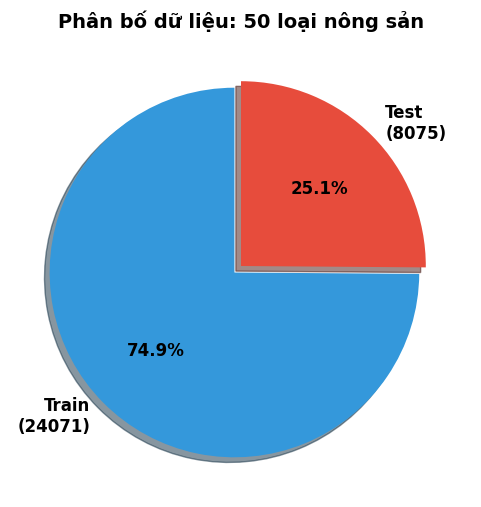

In [8]:

from tqdm.notebook import tqdm 
def count_images_fast(base_dir, class_list, desc="Đang đếm"):
    total_count = 0
    
    for class_name in tqdm(class_list, desc=desc):
        class_path = os.path.join(base_dir, class_name)
        if os.path.exists(class_path):
            num_files = len(os.listdir(class_path))
            total_count += num_files
            
    return total_count

# Đếm Train
num_train = count_images_fast(TRAIN_DIR, SELECTED_CLASSES, desc="Đếm tập Train")

# Đếm Test
num_test = count_images_fast(TEST_DIR, SELECTED_CLASSES, desc="Đếm tập Test")

total_images = num_train + num_test

# Tính %
train_percent = (num_train / total_images) * 100
test_percent = (num_test / total_images) * 100

print("\n" + "="*40)
print(f" KẾT QUẢ THỐNG KÊ ({len(SELECTED_CLASSES)} LỚP):")
print("="*40)
print(f"   - Tổng cộng:  {total_images:,} ảnh")
print(f"   + Train:      {num_train:,} ảnh ({train_percent:.2f}%)")
print(f"   + Test:       {num_test:,} ảnh ({test_percent:.2f}%)")
print("="*40)

labels = [f'Train\n({num_train})', f'Test\n({num_test})']
sizes = [num_train, num_test]
colors = ['#3498db', '#e74c3c'] 
explode = (0.05, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
            shadow=True, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
plt.title(f"Phân bố dữ liệu: {len(SELECTED_CLASSES)} loại nông sản", fontsize=14, fontweight='bold')
plt.show()
    

In [9]:
def plot_class_distribution(dir_path, selected_classes, title="Phân bố dữ liệu"):
    """
    Hàm vẽ biểu đồ phân bố dữ liệu chỉ cho các lớp nằm trong danh sách chọn lọc.
    """
    
    data = []
    
    # Chỉ duyệt qua danh sách 50 lớp đã chọn
    for class_name in selected_classes:
        folder_path = os.path.join(dir_path, class_name)
        
        if os.path.exists(folder_path):
            count = len(os.listdir(folder_path))
            data.append({'Class': class_name, 'Count': count})
        else:
            data.append({'Class': class_name, 'Count': 0})

    df = pd.DataFrame(data)
    df = df.sort_values(by='Count', ascending=False)
    
    # Tính thống kê cơ bản
    total_imgs = df['Count'].sum()
    avg_imgs = df['Count'].mean()
    min_imgs = df['Count'].min()
    max_imgs = df['Count'].max()

    # --- VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(12, 14)) 
    
    ax = sns.barplot(data=df, x='Count', y='Class', palette='viridis')
    
    plt.title(f'{title}\nTổng: {total_imgs} | TB: {avg_imgs:.1f} | Min: {min_imgs} | Max: {max_imgs}', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Số lượng ảnh', fontsize=12)
    plt.ylabel('Tên loại nông sản', fontsize=12)
    
    # Vẽ đường trung bình (Màu đỏ đứt nét)
    plt.axvline(x=avg_imgs, color='red', linestyle='--', label=f'Trung bình: {avg_imgs:.0f}')
    plt.legend()
    
    # Thêm con số cụ thể vào cuối mỗi thanh (Label Value)
    for i, v in enumerate(df['Count']):
        ax.text(v + 3, i + 0.25, str(v), color='black', fontsize=9)
        
    plt.tight_layout()
    plt.show()
    
    return df

/tmp/ipykernel_26/2575693054.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Count', y='Class', palette='viridis')


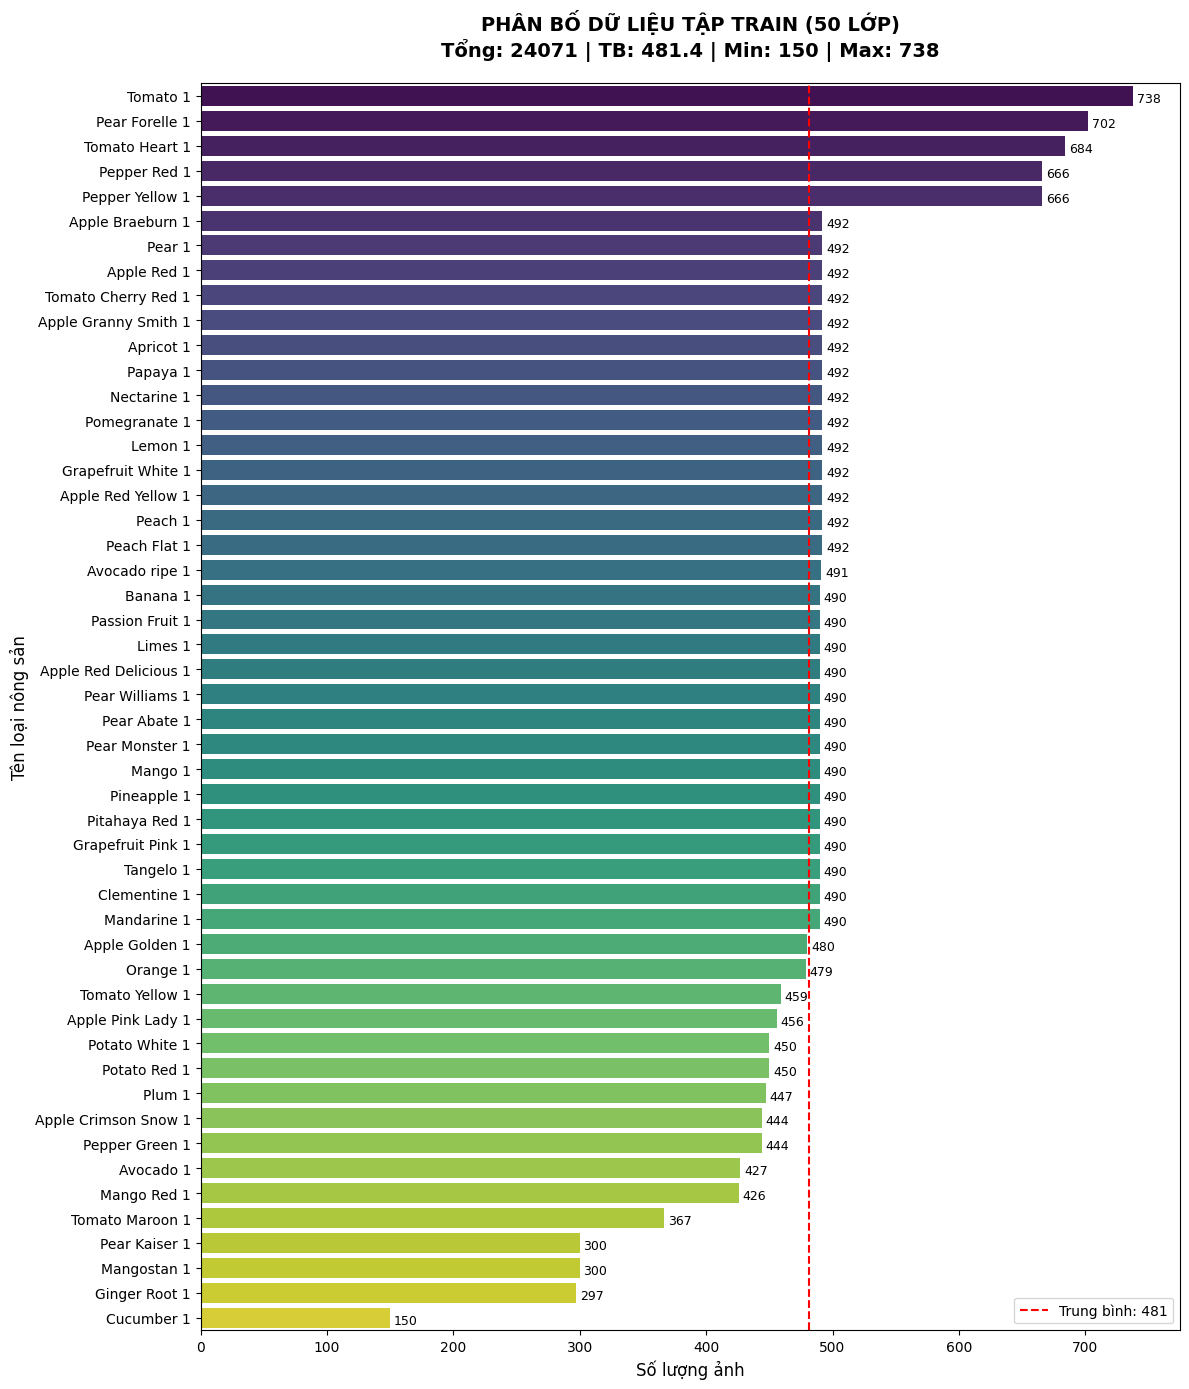

/tmp/ipykernel_26/2575693054.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Count', y='Class', palette='viridis')


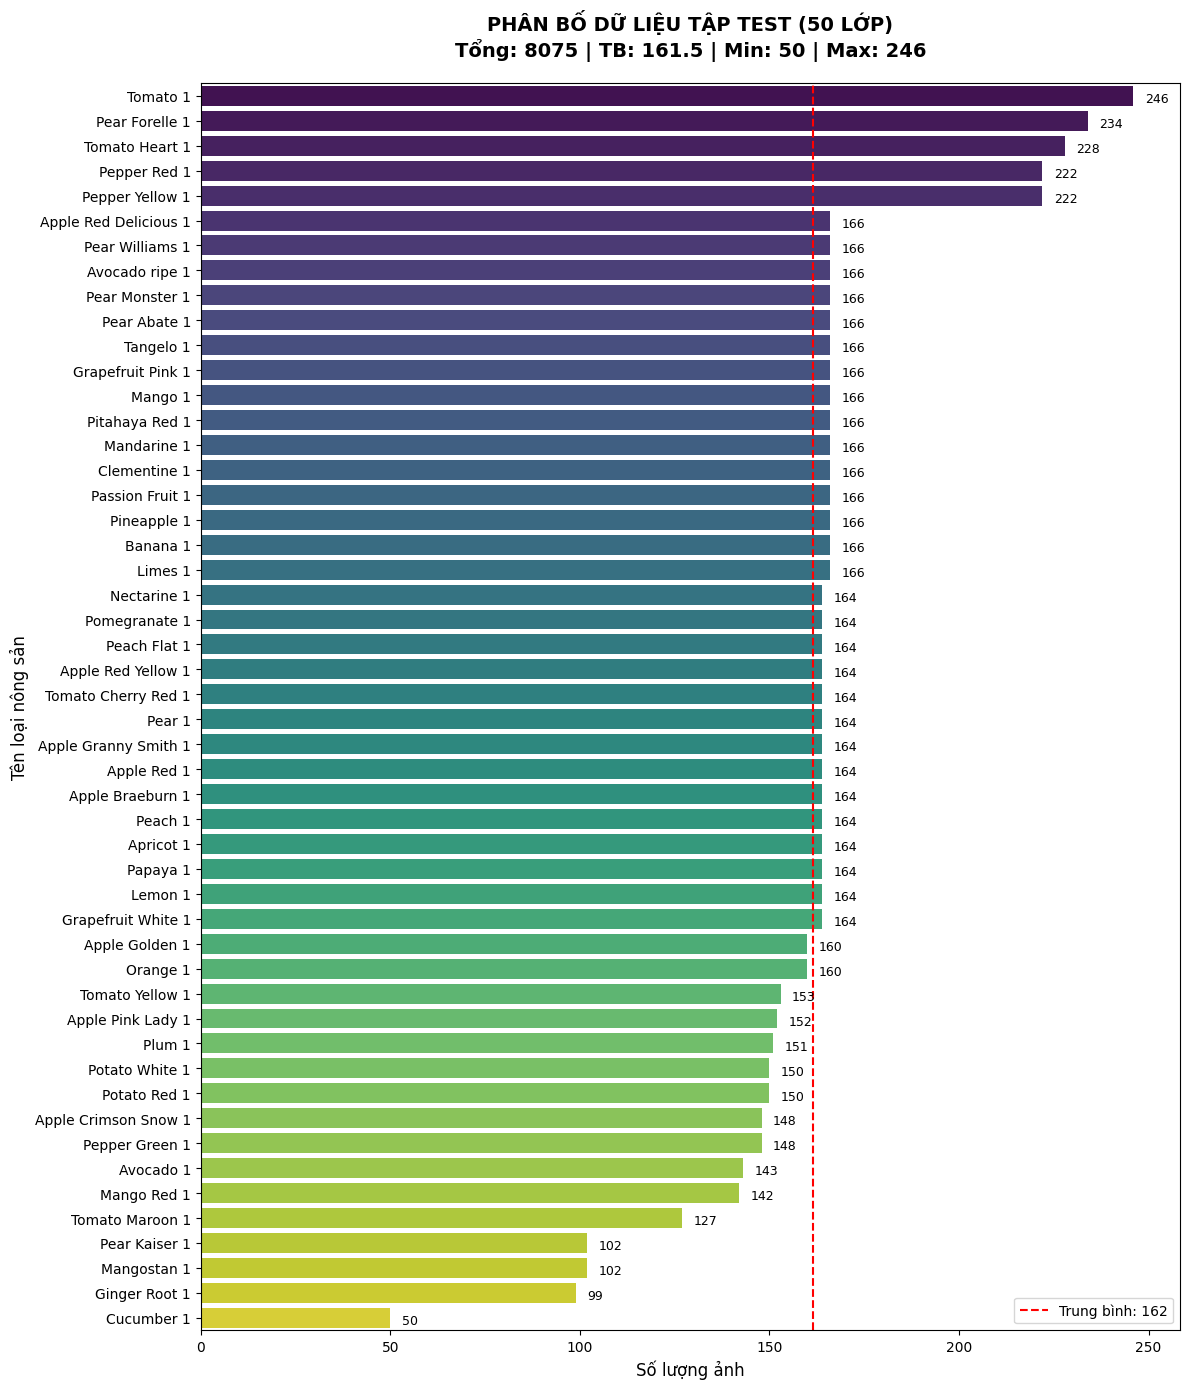

In [10]:
df_train = plot_class_distribution(TRAIN_DIR, SELECTED_CLASSES, title="PHÂN BỐ DỮ LIỆU TẬP TRAIN (50 LỚP)")

df_test = plot_class_distribution(TEST_DIR, SELECTED_CLASSES, title="PHÂN BỐ DỮ LIỆU TẬP TEST (50 LỚP)")

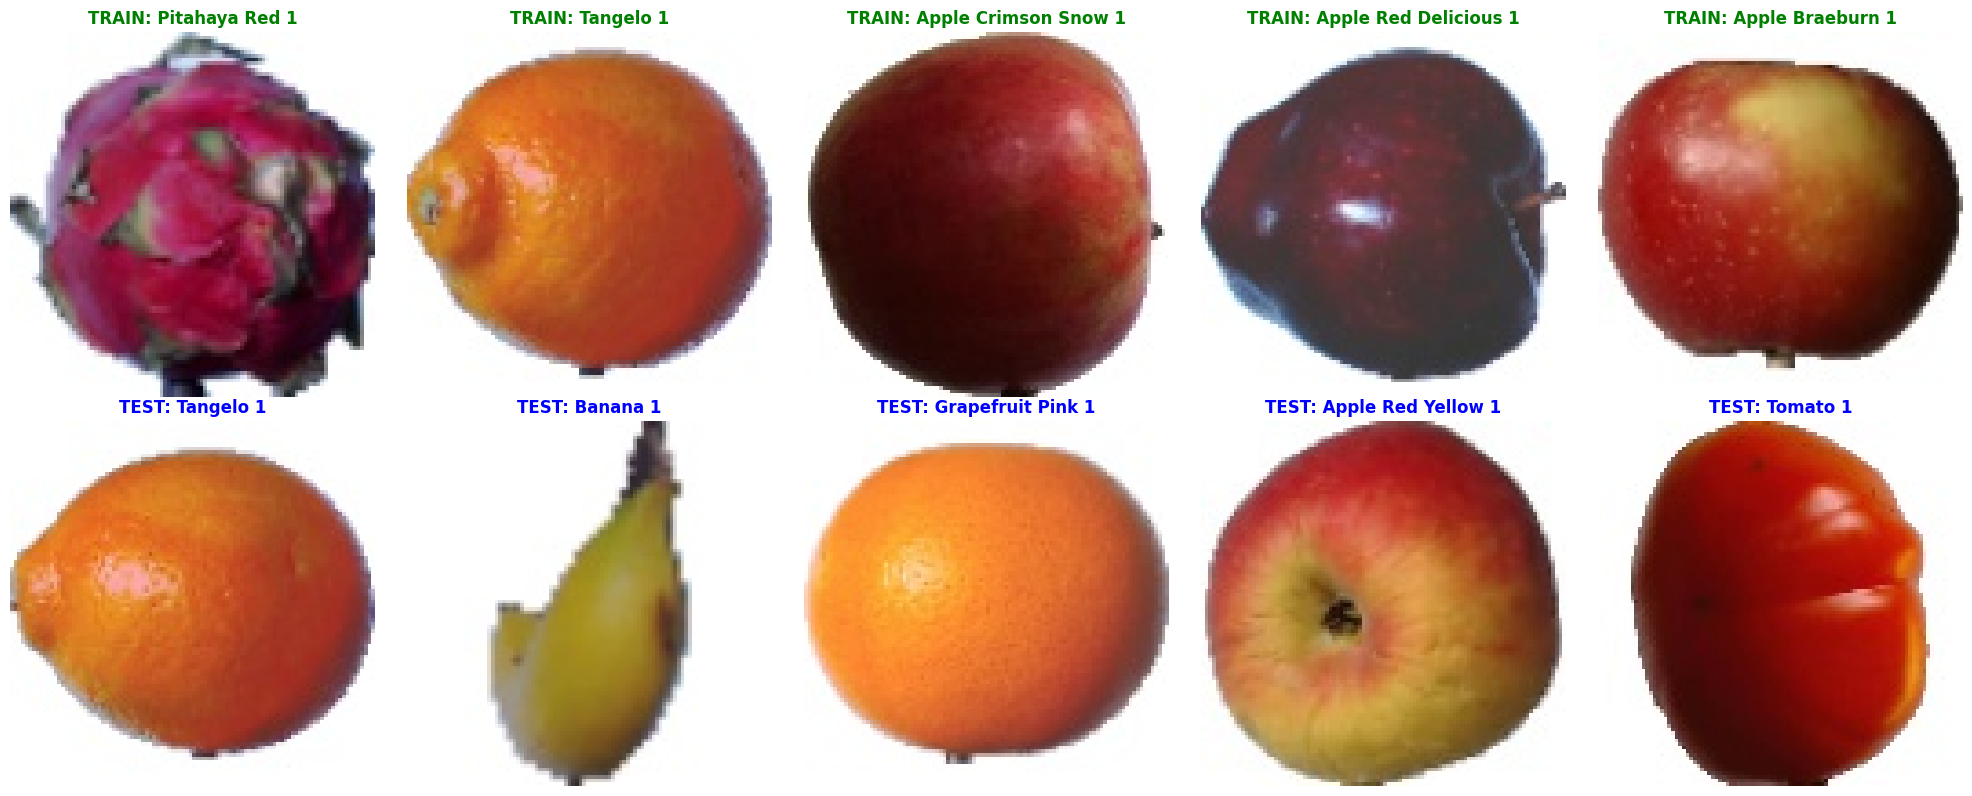

In [11]:
import matplotlib.image as mpimg
import random

def visualize_samples(train_path, test_path, class_list, num_samples=5):
    """
    Hàm vẽ 2 hàng ảnh:
    - Hàng trên: Ảnh ngẫu nhiên từ tập Train
    - Hàng dưới: Ảnh ngẫu nhiên từ tập Test
    """
    plt.figure(figsize=(20, 8)) 
    
    # --- HÀNG 1: TẬP TRAIN ---
    for i in range(num_samples):
        random_class = random.choice(class_list)
        class_dir = os.path.join(train_path, random_class)
        
        if os.path.exists(class_dir) and len(os.listdir(class_dir)) > 0:
            random_image = random.choice(os.listdir(class_dir))
            img_path = os.path.join(class_dir, random_image)
            
            ax = plt.subplot(2, num_samples, i + 1)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(f"TRAIN: {random_class}", color='green', fontweight='bold')
            plt.axis('off')
    
    # --- HÀNG 2: TẬP TEST ---
    for i in range(num_samples):
        random_class = random.choice(class_list)
        class_dir = os.path.join(test_path, random_class)
        
        if os.path.exists(class_dir) and len(os.listdir(class_dir)) > 0:
            random_image = random.choice(os.listdir(class_dir))
            img_path = os.path.join(class_dir, random_image)
            
            ax = plt.subplot(2, num_samples, i + 1 + num_samples) # Vị trí hàng dưới
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(f"TEST: {random_class}", color='blue', fontweight='bold')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    
visualize_samples(TRAIN_DIR, TEST_DIR, SELECTED_CLASSES)

## Train model


#### Swin Transformer V2

In [12]:
!pip install -q protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4.

In [13]:
!pip install -q transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, Swinv2ForImageClassification
import os
import copy
import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from PIL import Image
import torch.nn.functional as F

print(f" Đang dùng dữ liệu tại: {TRAIN_DIR}")

BATCH_SIZE = 16       
EPOCHS = 20           
LEARNING_RATE = 1e-5  
PATIENCE = 5          

# Model Swin V2 Base (Size 192x192)
MODEL_NAME = "microsoft/swinv2-base-patch4-window12-192-22k"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"THIẾT BỊ HUẤN LUYỆN: {device}")

2026-01-09 17:03:13.490094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767978193.673906      26 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767978193.724021      26 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767978194.155873      26 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767978194.155913      26 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767978194.155916      26 computation_placer.cc:177] computation placer alr

 Đang dùng dữ liệu tại: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
THIẾT BỊ HUẤN LUYỆN: cuda


In [14]:
# Swin V2 yêu cầu size 192x192
print(" Đang tải Processor từ HuggingFace...")
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

data_transform = transforms.Compose([
    transforms.Resize((192, 192)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

print(" Đang tạo Dataset (Lọc 50 lớp)...")

train_dataset = SelectiveImageFolder(TRAIN_DIR, transform=data_transform)
test_dataset = SelectiveImageFolder(TEST_DIR, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print("-" * 30)
print(f" Đã tìm thấy {num_classes} loại trái cây và rau củ.")
print(f" Train: {len(train_dataset)} ảnh | Test: {len(test_dataset)} ảnh")

 Đang tải Processor từ HuggingFace...


preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 Đang tạo Dataset (Lọc 50 lớp)...
------------------------------
 Đã tìm thấy 50 loại trái cây và rau củ.
 Train: 24071 ảnh | Test: 8075 ảnh


In [15]:
print(f" Đang tải Pre-trained Model: {MODEL_NAME}...")
model = Swinv2ForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# ==============================================================================
# [KỸ THUẬT TỐI ƯU 4]: LABEL SMOOTHING (Làm mềm nhãn)
# Tác dụng: Thay vì ép nhãn 1.0/0.0, dùng 0.9/0.1 để tránh Overfitting.
# ==============================================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 

# ==============================================================================
# [KỸ THUẬT TỐI ƯU 3]: REDUCE LR ON PLATEAU (Giảm tốc độ học tự động)
# Tác dụng: Giảm LR đi một nửa nếu sau 2 epoch Acc không tăng.
# ==============================================================================
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7
)

print(" Model đã sẵn sàng với Label Smoothing & ReduceLR!")

 Đang tải Pre-trained Model: microsoft/swinv2-base-patch4-window12-192-22k...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window12-192-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([50, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([50]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

 Model đã sẵn sàng với Label Smoothing & ReduceLR!


In [16]:
print(f" BẮT ĐẦU TRAIN ({EPOCHS} Epochs)...")

best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        
        # ======================================================================
        # [KỸ THUẬT TỐI ƯU 5]: GRADIENT CLIPPING (Cắt ngọn Gradient)
        # Tác dụng: Ngăn bùng nổ Gradient, giúp model hội tụ ổn định.
        # ======================================================================
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item())

    # --- VALIDATION PHASE ---
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    train_acc = 100 * correct / total
    test_acc = 100 * correct_test / total_test
    
    # Lưu history
    history['train_loss'].append(running_loss/len(train_loader))
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    
    print(f"   Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% |  Test Acc: {test_acc:.2f}%")
    
    # Cập nhật Scheduler
    scheduler.step(test_acc)
    
    # ==========================================================================
    # [KỸ THUẬT TỐI ƯU 1]: MODEL CHECKPOINT (Lưu vết tối ưu)
    # Tác dụng: Chỉ lưu model khi có kết quả tốt nhất (Best Acc).
    # ==========================================================================
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
        # SỬA LẠI ĐƯỜNG DẪN LƯU (Lưu vào thư mục hiện tại ./ thay vì dataset gốc)
        save_path = './best_swin_v2.pth'
        torch.save(model.state_dict(), save_path)
        
        epochs_no_improve = 0
        print(f"   Đã lưu model mới vào: {save_path}")
    else:
        epochs_no_improve += 1
        
    # ==========================================================================
    # [KỸ THUẬT TỐI ƯU 2]: EARLY STOPPING (Dừng sớm)
    # Tác dụng: Giảm LR đi một nửa nếu sau 2 epoch Acc không tăng.
    # ==========================================================================
    if epochs_no_improve >= PATIENCE:
        print(f" Dừng sớm (Early Stopping) sau {PATIENCE} epochs không cải thiện!")
        break

print(f" Train xong! Acc tốt nhất (Chưa TTA): {best_acc:.2f}%")
model.load_state_dict(best_model_wts)

 BẮT ĐẦU TRAIN (20 Epochs)...


Epoch 1/20:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.8339 | Train Acc: 97.27% |  Test Acc: 100.00%
   Đã lưu model mới vào: ./best_swin_v2.pth


Epoch 2/20:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7065 | Train Acc: 100.00% |  Test Acc: 100.00%


Epoch 3/20:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7045 | Train Acc: 100.00% |  Test Acc: 100.00%


Epoch 4/20:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7038 | Train Acc: 100.00% |  Test Acc: 100.00%


Epoch 5/20:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7030 | Train Acc: 100.00% |  Test Acc: 100.00%


Epoch 6/20:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7028 | Train Acc: 100.00% |  Test Acc: 100.00%
 Dừng sớm (Early Stopping) sau 5 epochs không cải thiện!
 Train xong! Acc tốt nhất (Chưa TTA): 100.00%


<All keys matched successfully>

 Đang chạy Test cho: Swin Transformer V2 (Size 192)...
 Tổng số ảnh Test: 8075


Testing Swin Transformer V2:   0%|          | 0/8075 [00:00<?, ?it/s]


 KẾT QUẢ: Swin Transformer V2
 Accuracy thực tế: 97.31%
------------------------------------------------------------
                       precision    recall  f1-score   support

     Apple Braeburn 1     0.9880    1.0000    0.9939       164
 Apple Crimson Snow 1     1.0000    0.7635    0.8659       148
       Apple Golden 1     0.9815    0.9938    0.9876       160
 Apple Granny Smith 1     0.9302    0.9756    0.9524       164
    Apple Pink Lady 1     0.8128    1.0000    0.8968       152
          Apple Red 1     1.0000    0.9817    0.9908       164
Apple Red Delicious 1     1.0000    1.0000    1.0000       166
   Apple Red Yellow 1     1.0000    0.9695    0.9845       164
            Apricot 1     0.8701    0.9390    0.9032       164
            Avocado 1     1.0000    1.0000    1.0000       143
       Avocado ripe 1     1.0000    1.0000    1.0000       166
             Banana 1     1.0000    0.9940    0.9970       166
         Clementine 1     1.0000    0.9337    0.9657       166

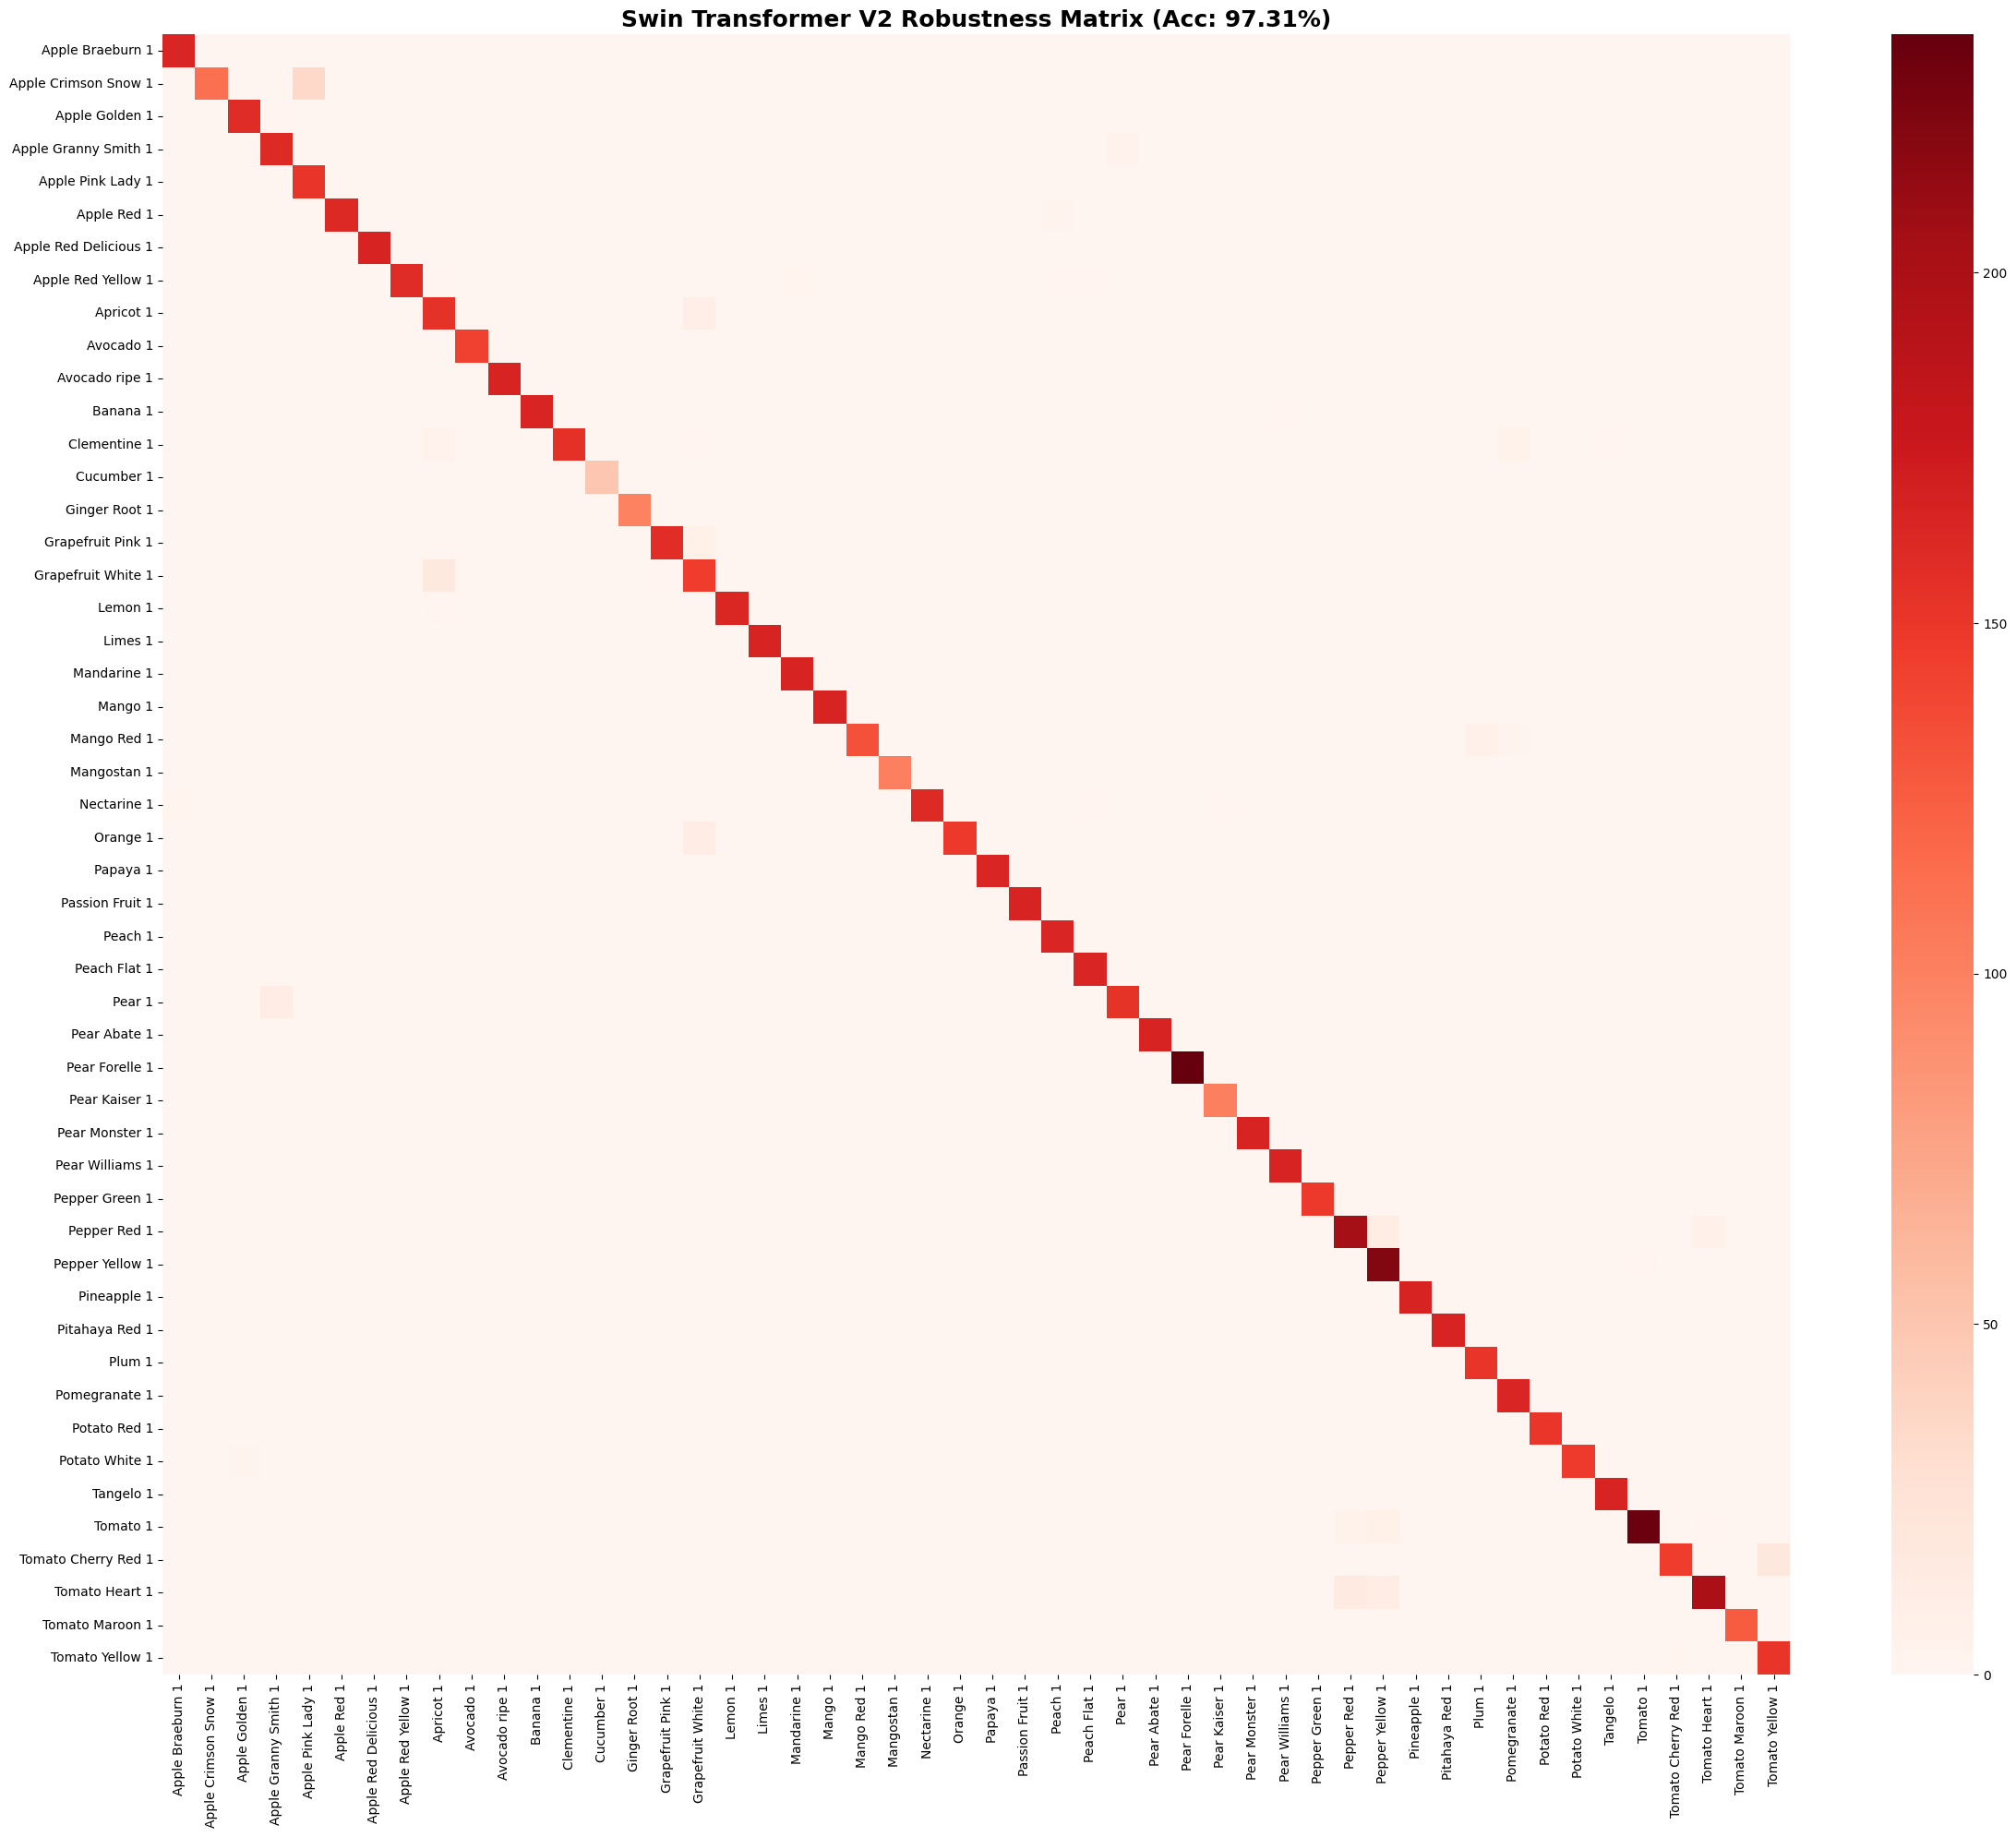


 KIỂM TRA MẪU THỰC TẾ:
  Tổng số lỗi sai: 217 / 8075
 Ví dụ 5 lỗi sai đầu tiên (Text):
   file: 127_100.jpg          | Thật: Apple Crimson Snow 1 -> Máy đoán: Apple Pink Lady 1
   file: r_42_100.jpg         | Thật: Apple Crimson Snow 1 -> Máy đoán: Apple Pink Lady 1
   file: r_24_100.jpg         | Thật: Apple Crimson Snow 1 -> Máy đoán: Apple Pink Lady 1
   file: r_23_100.jpg         | Thật: Apple Crimson Snow 1 -> Máy đoán: Apple Pink Lady 1
   file: 122_100.jpg          | Thật: Apple Crimson Snow 1 -> Máy đoán: Apple Pink Lady 1

 Đang vẽ ảnh minh họa (3 ĐÚNG - 2 SAI)...


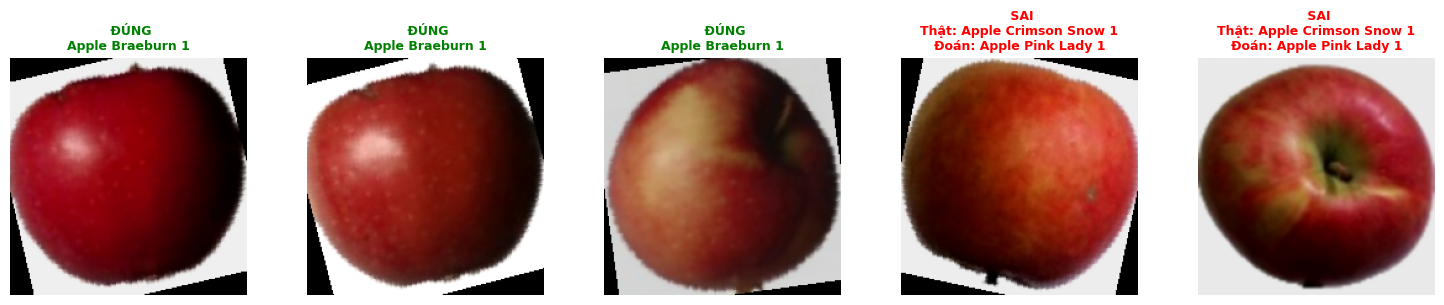


############################################################



In [17]:
from PIL import Image
from tqdm.notebook import tqdm
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

CURRENT_IMG_SIZE = 192  

CURRENT_NAME = "Swin Transformer V2" 

CURRENT_COLOR = 'Reds'

print(f" Đang chạy Test cho: {CURRENT_NAME} (Size {CURRENT_IMG_SIZE})...")

# 1. Định nghĩa Transform Gây Nhiễu
stress_transform = transforms.Compose([
    transforms.Resize((CURRENT_IMG_SIZE, CURRENT_IMG_SIZE)),
    
    # --- CÁC TÁC NHÂN GÂY NHIỄU ---
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 1.0)),
    transforms.RandomRotation(15),
    # ------------------------------
    
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# 2. Tạo danh sách file ảnh Test
sorted_classes = sorted(SELECTED_CLASSES)
class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted_classes)}

test_files = []
test_labels = [] 

for class_name in sorted_classes:
    class_path = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_path):
        class_idx = class_to_idx[class_name]
        for f in os.listdir(class_path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                test_files.append(os.path.join(class_path, f))
                test_labels.append(class_idx)

print(f" Tổng số ảnh Test: {len(test_files)}")

# 3. Chạy Loop Dự đoán
model.eval() 
pred_labels = []
true_labels_list = []

# Lưu lại index để vẽ
correct_indices = []
error_indices = []
errors_text = []

with torch.no_grad():
    for i in tqdm(range(len(test_files)), desc=f"Testing {CURRENT_NAME}"):
        img_path = test_files[i]
        label = test_labels[i]
        
        img = Image.open(img_path).convert('RGB')
        input_tensor = stress_transform(img).unsqueeze(0).to(device)
        
        output = model(input_tensor).logits
        pred_label = torch.argmax(output, dim=1).item()
        
        pred_labels.append(pred_label)
        true_labels_list.append(label)
        
        # Phân loại Đúng/Sai
        if pred_label == label:
            if len(correct_indices) < 3: # Lấy tối đa 3 cái đúng
                correct_indices.append(i)
        else:
            errors_text.append((os.path.basename(test_files[i]), sorted_classes[label], sorted_classes[pred_label]))
            if len(error_indices) < 2: # Lấy tối đa 2 cái sai
                error_indices.append(i)

# 4. Tính toán & Báo cáo Metrics
acc = accuracy_score(true_labels_list, pred_labels)

print(f"\n KẾT QUẢ: {CURRENT_NAME}")
print(f" Accuracy thực tế: {acc * 100:.2f}%")
print("-" * 60)
print(classification_report(true_labels_list, pred_labels, target_names=sorted_classes, digits=4))

# 5. Vẽ Confusion Matrix
plt.figure(figsize=(24, 20))
cm = confusion_matrix(true_labels_list, pred_labels)
sns.heatmap(cm, annot=False, fmt='d', cmap=CURRENT_COLOR, 
            xticklabels=sorted_classes, yticklabels=sorted_classes)
plt.title(f'{CURRENT_NAME} Robustness Matrix (Acc: {acc*100:.2f}%)', fontsize=18, fontweight='bold')
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# 6. LIỆT KÊ LỖI SAI (TEXT)
print("\n KIỂM TRA MẪU THỰC TẾ:")
print(f"  Tổng số lỗi sai: {len(errors_text)} / {len(test_files)}")
if len(errors_text) > 0:
    print(" Ví dụ 5 lỗi sai đầu tiên (Text):")
    for f, t, p in errors_text[:5]:
        print(f"   file: {f:<20} | Thật: {t:<20} -> Máy đoán: {p}")
else:
    print(" Không có lỗi sai nào!")

# 7. VẼ ẢNH MINH HỌA (3 ĐÚNG - 2 SAI)
print("\n Đang vẽ ảnh minh họa (3 ĐÚNG - 2 SAI)...")

# Hàm nội bộ để vẽ từng ảnh
def show_img_inline(idx, ax, is_correct):
    img_path = test_files[idx]
    true_name = sorted_classes[true_labels_list[idx]]
    pred_name = sorted_classes[pred_labels[idx]]
    
    img = Image.open(img_path).convert('RGB')
    tensor = stress_transform(img)

    # Un-normalize
    mean = torch.tensor(processor.image_mean).view(3, 1, 1)
    std = torch.tensor(processor.image_std).view(3, 1, 1)
    img_show = tensor * std + mean
    img_show = img_show.permute(1, 2, 0).numpy()
    img_show = np.clip(img_show, 0, 1)

    ax.imshow(img_show)
    if is_correct:
        ax.set_title(f" ĐÚNG\n{true_name}", color='green', fontweight='bold', fontsize=9)
    else:
        ax.set_title(f" SAI\nThật: {true_name}\nĐoán: {pred_name}", color='red', fontweight='bold', fontsize=9)
    ax.axis('off')

# KHỞI TẠO PLOT
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

current_plot = 0
# Vẽ 3 ảnh ĐÚNG
for idx in correct_indices:
    if current_plot < 5:
        show_img_inline(idx, axes[current_plot], is_correct=True)
        current_plot += 1

# Vẽ 2 ảnh SAI
for idx in error_indices:
    if current_plot < 5:
        show_img_inline(idx, axes[current_plot], is_correct=False)
        current_plot += 1

for i in range(current_plot, 5): axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "#"*60 + "\n")

#### ConvNeXt V2

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import copy
import time
from tqdm.notebook import tqdm 

from transformers import AutoImageProcessor, ConvNextV2ForImageClassification
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

print(f" Đang dùng dữ liệu tại: {TRAIN_DIR}")

# SIÊU THAM SỐ 
BATCH_SIZE = 16       
EPOCHS = 20   
LEARNING_RATE = 2e-5
PATIENCE = 5         
LR_PATIENCE = 2       
MIN_LR = 1e-7         
MODEL_NAME_CONV = "facebook/convnextv2-base-1k-224"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" ĐANG KÍCH HOẠT CONVNEXT V2 TRÊN: {device}")


 Đang dùng dữ liệu tại: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
 ĐANG KÍCH HOẠT CONVNEXT V2 TRÊN: cuda


In [19]:
# --- 2. CHUẨN BỊ DỮ LIỆU ---
# ConvNeXt dùng size 224x224 
print(" Đang tải Processor ConvNeXt...")
processor = AutoImageProcessor.from_pretrained(MODEL_NAME_CONV)

data_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

print(" Đang tạo Dataset (Lọc 50 lớp)...")
train_dataset_conv = SelectiveImageFolder(TRAIN_DIR, transform=data_transform)
test_dataset_conv = SelectiveImageFolder(TEST_DIR, transform=data_transform)

train_loader = DataLoader(train_dataset_conv, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset_conv, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

num_classes = len(train_dataset_conv.classes)

print("-" * 30)
print(f" Dữ liệu sẵn sàng cho ConvNeXt: {num_classes} lớp.")
print(f" Train: {len(train_dataset_conv)} ảnh | Test: {len(test_dataset_conv)} ảnh")

 Đang tải Processor ConvNeXt...


preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

 Đang tạo Dataset (Lọc 50 lớp)...
------------------------------
 Dữ liệu sẵn sàng cho ConvNeXt: 50 lớp.
 Train: 24071 ảnh | Test: 8075 ảnh


In [20]:
# --- 3. TẢI MODEL ---
print(f" Đang tải Pre-trained Model: {MODEL_NAME_CONV}...")
model = ConvNextV2ForImageClassification.from_pretrained(
    MODEL_NAME_CONV,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model.to(device)

if torch.cuda.device_count() > 1:
    print(f" Kích hoạt 2 GPU cho ConvNeXt!")
    model = nn.DataParallel(model)

# --- CÁC KỸ THUẬT TỐI ƯU ---
# 1. Optimizer AdamW
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# 2. [KỸ THUẬT] LABEL SMOOTHING (Chống Overfitting)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 3. [KỸ THUẬT] REDUCE LR ON PLATEAU (Giảm tốc độ học)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=LR_PATIENCE, min_lr=MIN_LR
)

 Đang tải Pre-trained Model: facebook/convnextv2-base-1k-224...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-base-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([50]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([50, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
print(f" BẮT ĐẦU HUẤN LUYỆN CONVNEXT ({EPOCHS} Epochs)...")

best_acc = 0.0
# Lưu ý: model.module.state_dict() nếu dùng DataParallel, còn không thì model.state_dict()
# Để an toàn ta copy cái đang có
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
history_conv = {'train_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Lấy LR hiện tại để in ra
    current_lr = optimizer.param_groups[0]['lr']
    loop = tqdm(train_loader, desc=f"Vòng {epoch+1}/{EPOCHS} [LR={current_lr:.1e}]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()

        # 4. [KỸ THUẬT] GRADIENT CLIPPING
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item())

    # --- TEST ---
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    test_acc = 100 * correct_test / total_test

    history_conv['train_loss'].append(running_loss/len(train_loader))
    history_conv['train_acc'].append(train_acc)
    history_conv['test_acc'].append(test_acc)

    # Cập nhật Scheduler
    scheduler.step(test_acc)

    print(f"   Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    # 5. [KỸ THUẬT] CHECKPOINT & EARLY STOPPING
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
        # Lưu file tên khác để không đè lên Swin, lưu vào ./
        save_path = './best_convnext_v2.pth'
        torch.save(model.state_dict(), save_path)
        
        epochs_no_improve = 0
        print(f"    Đã lưu model vào {save_path}")
    else:
        epochs_no_improve += 1
        print(f"    Không tiến bộ ({epochs_no_improve}/{PATIENCE})")

    if epochs_no_improve >= PATIENCE:
        print(f" Dừng sớm (Early Stopping)!")
        break

print(f"\n Train xong ConvNeXt! Acc tốt nhất: {best_acc:.2f}%")
model.load_state_dict(best_model_wts)

 BẮT ĐẦU HUẤN LUYỆN CONVNEXT (20 Epochs)...


Vòng 1/20 [LR=2.0e-05]:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 1.1598 | Train Acc: 96.51% | Test Acc: 100.00%
    Đã lưu model vào ./best_convnext_v2.pth


Vòng 2/20 [LR=2.0e-05]:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7030 | Train Acc: 99.98% | Test Acc: 100.00%
    Không tiến bộ (1/5)


Vòng 3/20 [LR=2.0e-05]:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7021 | Train Acc: 100.00% | Test Acc: 100.00%
    Không tiến bộ (2/5)


Vòng 4/20 [LR=2.0e-05]:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7072 | Train Acc: 99.87% | Test Acc: 100.00%
    Không tiến bộ (3/5)


Vòng 5/20 [LR=1.0e-05]:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7021 | Train Acc: 100.00% | Test Acc: 100.00%
    Không tiến bộ (4/5)


Vòng 6/20 [LR=1.0e-05]:   0%|          | 0/1505 [00:00<?, ?it/s]

   Loss: 0.7021 | Train Acc: 100.00% | Test Acc: 100.00%
    Không tiến bộ (5/5)
 Dừng sớm (Early Stopping)!

 Train xong ConvNeXt! Acc tốt nhất: 100.00%


<All keys matched successfully>

 Đang chạy Test cho: ConvNeXt V2 (Size 224)...
 Tổng số ảnh Test: 8075


Testing ConvNeXt V2:   0%|          | 0/8075 [00:00<?, ?it/s]


 KẾT QUẢ: ConvNeXt V2
 Accuracy thực tế: 94.96%
------------------------------------------------------------
                       precision    recall  f1-score   support

     Apple Braeburn 1     0.8564    0.9451    0.8986       164
 Apple Crimson Snow 1     0.9459    0.7095    0.8108       148
       Apple Golden 1     1.0000    0.9688    0.9841       160
 Apple Granny Smith 1     0.9879    0.9939    0.9909       164
    Apple Pink Lady 1     0.7801    0.9803    0.8688       152
          Apple Red 1     0.9930    0.8659    0.9251       164
Apple Red Delicious 1     0.9881    1.0000    0.9940       166
   Apple Red Yellow 1     0.9588    0.9939    0.9760       164
            Apricot 1     0.8471    0.8110    0.8287       164
            Avocado 1     1.0000    0.9930    0.9965       143
       Avocado ripe 1     1.0000    1.0000    1.0000       166
             Banana 1     1.0000    0.9759    0.9878       166
         Clementine 1     0.9064    0.9337    0.9199       166
       

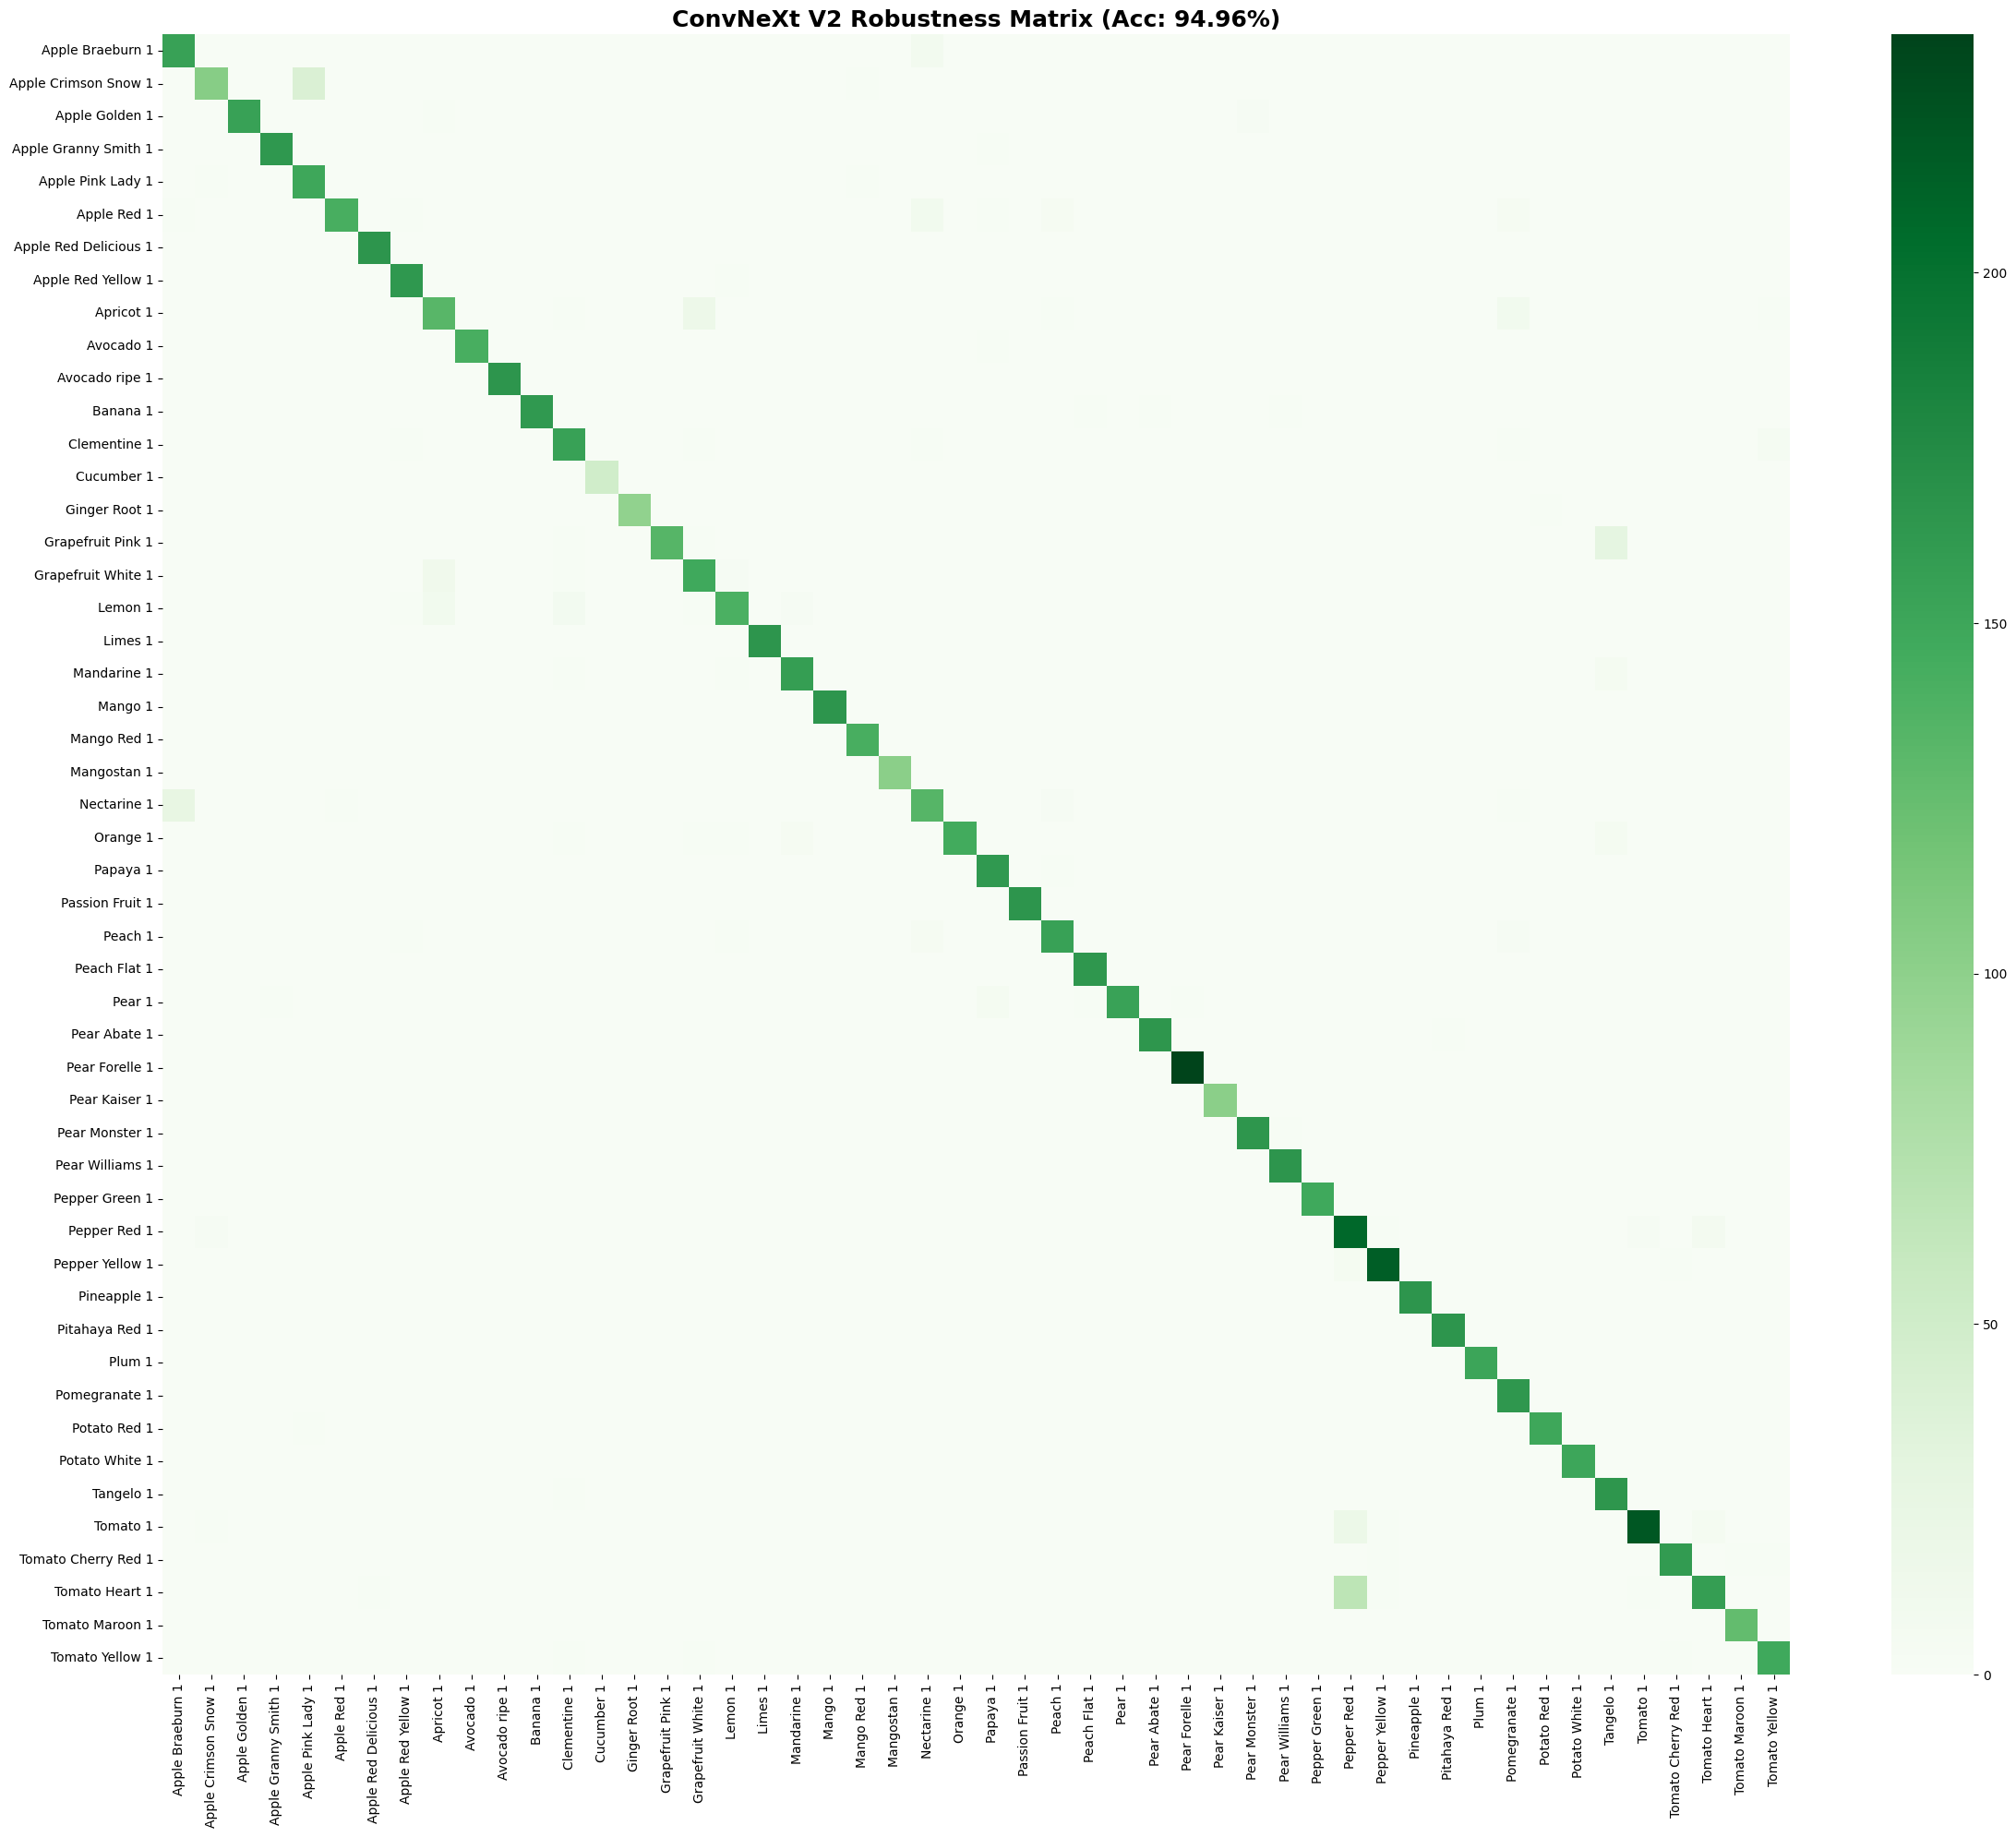


 KIỂM TRA MẪU THỰC TẾ:
  Tổng số lỗi sai: 407 / 8075
 Ví dụ 5 lỗi sai đầu tiên (Text):
   file: 45_100.jpg           | Thật: Apple Braeburn 1     -> Máy đoán: Nectarine 1
   file: r_6_100.jpg          | Thật: Apple Braeburn 1     -> Máy đoán: Nectarine 1
   file: r_57_100.jpg         | Thật: Apple Braeburn 1     -> Máy đoán: Nectarine 1
   file: r_66_100.jpg         | Thật: Apple Braeburn 1     -> Máy đoán: Nectarine 1
   file: r_40_100.jpg         | Thật: Apple Braeburn 1     -> Máy đoán: Nectarine 1

 Đang vẽ ảnh minh họa (3 ĐÚNG - 2 SAI)...


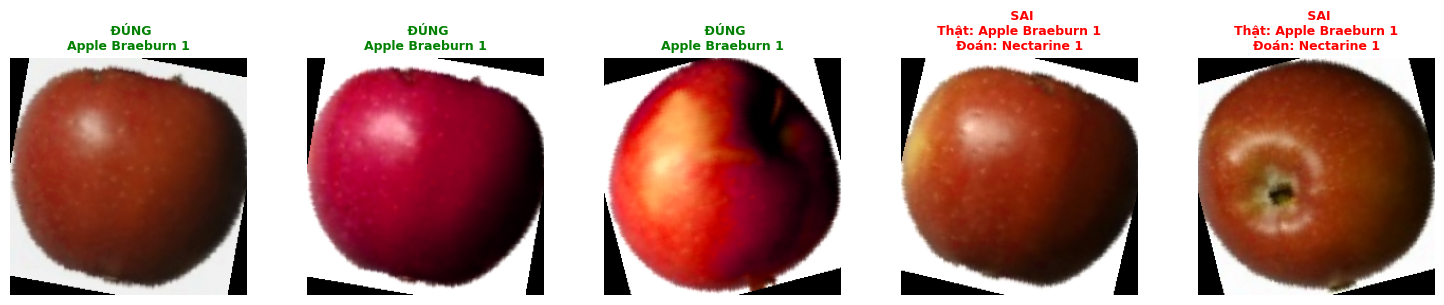


############################################################



In [22]:
CURRENT_IMG_SIZE = 224  

CURRENT_NAME = "ConvNeXt V2" 

CURRENT_COLOR = 'Greens'

print(f" Đang chạy Test cho: {CURRENT_NAME} (Size {CURRENT_IMG_SIZE})...")

# 1. Định nghĩa Transform Gây Nhiễu
stress_transform = transforms.Compose([
    transforms.Resize((CURRENT_IMG_SIZE, CURRENT_IMG_SIZE)),
    
    # --- CÁC TÁC NHÂN GÂY NHIỄU ---
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 1.0)),
    transforms.RandomRotation(15),
    # ------------------------------
    
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# 2. Tạo danh sách file ảnh Test
sorted_classes = sorted(SELECTED_CLASSES)
class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted_classes)}

test_files = []
test_labels = [] 

for class_name in sorted_classes:
    class_path = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_path):
        class_idx = class_to_idx[class_name]
        for f in os.listdir(class_path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                test_files.append(os.path.join(class_path, f))
                test_labels.append(class_idx)

print(f" Tổng số ảnh Test: {len(test_files)}")

# 3. Chạy Loop Dự đoán
model.eval() 
pred_labels = []
true_labels_list = []

# Lưu lại index để vẽ
correct_indices = []
error_indices = []
errors_text = []

with torch.no_grad():
    for i in tqdm(range(len(test_files)), desc=f"Testing {CURRENT_NAME}"):
        img_path = test_files[i]
        label = test_labels[i]
        
        img = Image.open(img_path).convert('RGB')
        input_tensor = stress_transform(img).unsqueeze(0).to(device)
        
        output = model(input_tensor).logits
        pred_label = torch.argmax(output, dim=1).item()
        
        pred_labels.append(pred_label)
        true_labels_list.append(label)
        
        # Phân loại Đúng/Sai
        if pred_label == label:
            if len(correct_indices) < 3: # Lấy tối đa 3 cái đúng
                correct_indices.append(i)
        else:
            errors_text.append((os.path.basename(test_files[i]), sorted_classes[label], sorted_classes[pred_label]))
            if len(error_indices) < 2: # Lấy tối đa 2 cái sai
                error_indices.append(i)

# 4. Tính toán & Báo cáo Metrics
acc = accuracy_score(true_labels_list, pred_labels)

print(f"\n KẾT QUẢ: {CURRENT_NAME}")
print(f" Accuracy thực tế: {acc * 100:.2f}%")
print("-" * 60)
print(classification_report(true_labels_list, pred_labels, target_names=sorted_classes, digits=4))

# 5. Vẽ Confusion Matrix
plt.figure(figsize=(24, 20))
cm = confusion_matrix(true_labels_list, pred_labels)
sns.heatmap(cm, annot=False, fmt='d', cmap=CURRENT_COLOR, 
            xticklabels=sorted_classes, yticklabels=sorted_classes)
plt.title(f'{CURRENT_NAME} Robustness Matrix (Acc: {acc*100:.2f}%)', fontsize=18, fontweight='bold')
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# 6. LIỆT KÊ LỖI SAI (TEXT)
print("\n KIỂM TRA MẪU THỰC TẾ:")
print(f"  Tổng số lỗi sai: {len(errors_text)} / {len(test_files)}")
if len(errors_text) > 0:
    print(" Ví dụ 5 lỗi sai đầu tiên (Text):")
    for f, t, p in errors_text[:5]:
        print(f"   file: {f:<20} | Thật: {t:<20} -> Máy đoán: {p}")
else:
    print(" Không có lỗi sai nào!")

# 7. VẼ ẢNH MINH HỌA (3 ĐÚNG - 2 SAI)
print("\n Đang vẽ ảnh minh họa (3 ĐÚNG - 2 SAI)...")

# Hàm nội bộ để vẽ từng ảnh
def show_img_inline(idx, ax, is_correct):
    img_path = test_files[idx]
    true_name = sorted_classes[true_labels_list[idx]]
    pred_name = sorted_classes[pred_labels[idx]]
    
    img = Image.open(img_path).convert('RGB')
    tensor = stress_transform(img)

    # Un-normalize
    mean = torch.tensor(processor.image_mean).view(3, 1, 1)
    std = torch.tensor(processor.image_std).view(3, 1, 1)
    img_show = tensor * std + mean
    img_show = img_show.permute(1, 2, 0).numpy()
    img_show = np.clip(img_show, 0, 1)

    ax.imshow(img_show)
    if is_correct:
        ax.set_title(f" ĐÚNG\n{true_name}", color='green', fontweight='bold', fontsize=9)
    else:
        ax.set_title(f" SAI\nThật: {true_name}\nĐoán: {pred_name}", color='red', fontweight='bold', fontsize=9)
    ax.axis('off')

# KHỞI TẠO PLOT
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

current_plot = 0
# Vẽ 3 ảnh ĐÚNG
for idx in correct_indices:
    if current_plot < 5:
        show_img_inline(idx, axes[current_plot], is_correct=True)
        current_plot += 1

# Vẽ 2 ảnh SAI
for idx in error_indices:
    if current_plot < 5:
        show_img_inline(idx, axes[current_plot], is_correct=False)
        current_plot += 1

for i in range(current_plot, 5): axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "#"*60 + "\n")